# Student Information


Name:李婉瑄

Student ID: 105065535

In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import plotly.plotly as py
import plotly.graph_objs as go
import math
import io
from collections import Counter, OrderedDict
import plotly.plotly as py
import plotly.graph_objs as go
import matplotlib.pyplot as plt
%matplotlib inline

# Step 1: Data Preparation

In [2]:
amazon_ori = open("C:\sentiment labelled sentences\\amazon_cells_labelled.txt", encoding='utf8').readlines()  #open file
imdb_ori= open("C:\sentiment labelled sentences\imdb_labelled.txt", encoding='utf8').readlines()
yelp_ori = open("C:\sentiment labelled sentences\yelp_labelled.txt", encoding='utf8').readlines()

In [3]:
print(type(amazon_ori))
print(type(imdb_ori))
print(type(yelp_ori))
print(len(amazon_ori))
print(len(imdb_ori))
print(len(yelp_ori))

<class 'list'>
<class 'list'>
<class 'list'>
1000
1000
1000


# Step 2.1 Converting Dictionary into Pandas dataframe

In [109]:
amazon = pd.read_csv("C:\sentiment labelled sentences\\amazon_cells_labelled.txt", header=None, encoding='utf8', sep="\t")  #自訂標題
yelp = pd.read_csv("C:\sentiment labelled sentences\yelp_labelled.txt", header=None, encoding='utf8', sep="\t")
imdb = pd.read_table("C:\sentiment labelled sentences\imdb_labelled.txt", header=None, encoding='utf8',sep="\s\t")

C:\Users\asus\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



In [110]:
imdb[175:185]

,0,1
175,Everything is appalling.,0
176,Artless camera-work endlessly presents us with...,0
177,The story is beyond stupid.,0
178,The script is was there a script?,0
179,The kids are annoying.,0
180,The lead man is charisma-free.,0
181,"Utterly without merit on any level, this is ak...",0
182,I'll even say it again  this is torture.,0
183,Maybe there would be a reasonable explanation ...,0
184,Not a pleasant voyage of self-discovery.,0


add one row for the label name

In [103]:
print(len(amazon))
print(len(yelp))
print(len(imdb))

1000
1000
1000


In [104]:
amazon.columns=['sentence','score']
yelp.columns=['sentence','score']
imdb.columns=['sentence','score']      

Insert one column 'label' for each table 

In [8]:
for i in range(len(amazon)+1):
    i='amazon'
amazon.insert(2,'label',i)
for i in range(len(yelp)+1):
    i='yelp'
yelp.insert(2,'label',i)
for i in range(len(imdb)+1):
    i='imdb'
imdb.insert(2,'label',i)

Merge them to one table by using 'concat', for "ignore_index=True", we ignore the origin index and reorder them

In [111]:
res=pd.concat([amazon, yelp, imdb], axis=0, ignore_index=True)
res[0:10]    #check the content

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
5,I have to jiggle the plug to get it to line up...,0
6,If you have several dozen or several hundred c...,0
7,If you are Razr owner...you must have this!,1
8,"Needless to say, I wasted my money.",0
9,What a waste of money and time!.,0


# Step 2.2 Familiarizing yourself with the Data

In [11]:
res[-5:]    #check last five records = res.tail(5)

,sentence,score,label
2995,I just got bored watching Jessice Lange take h...,0,imdb
2996,"Unfortunately, any virtue in this film's produ...",0,imdb
2997,"In a word, it is embarrassing.",0,imdb
2998,Exceptionally bad!,0,imdb
2999,All in all its an insult to one's intelligence...,0,imdb


In [12]:
res[0:5][['sentence','score']] #check first five records = res.head()

,sentence,score
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1


In [13]:
res.iloc[::100][0:]       #query every 100 records

,sentence,score,label
0,So there is no way for me to plug it in here i...,0,amazon
100,Integrated seamlessly with the Motorola RAZR p...,1,amazon
200,The color is even prettier than I thought it w...,1,amazon
300,Sending it back.,0,amazon
400,what a disappointment,0,amazon
500,"The bose noise cancelling is amazing, which is...",1,amazon
600,Their Research and Development division obviou...,1,amazon
700,"Also, the phone doesn't seem to accept anythin...",0,amazon
800,"Good , works fine.",1,amazon
900,"This was utterly confusing at first, which cau...",0,amazon


# Step 3 Data mining using pandas

### 3.1 Missing Values

In [14]:
yelp.isnull()

,sentence,score,label
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
5,False,False,False
6,False,False,False
7,False,False,False
8,False,False,False
9,False,False,False


In [15]:
def check_missing_values(row):
    """ functions that check and verifies if there are missing values in dataframe """
    counter = 0
    for element in row:
        if element == True:
            counter+=1
    return ("The amoung of missing records is: ", counter)

In [16]:
res.isnull().apply(lambda x: check_missing_values(x))

sentence    (The amoung of missing records is: , 0)
score       (The amoung of missing records is: , 0)
label       (The amoung of missing records is: , 0)
dtype: object

In [17]:
dummy_series = pd.Series(["what a bad day"], index=["sentence"])  #add one dummy word in 'sentence' column

In [18]:
dummy_series

sentence    what a bad day
dtype: object

In [19]:
len(res)

3000

In [112]:
result_series = res.append(dummy_series, ignore_index=True)  #add it into res table
len(result_series)

3001

In [113]:
result_series.isnull().apply(lambda x: check_missing_values(x)) 

0              (The amoung of missing records is: , 1)
1              (The amoung of missing records is: , 1)
sentence    (The amoung of missing records is: , 3000)
dtype: object

### 3.2 Dealing with Duplicate Data

In [23]:
res.duplicated()

0       False
1       False
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13      False
14      False
15      False
16      False
17      False
18      False
19      False
20      False
21      False
22      False
23      False
24      False
25      False
26      False
27      False
28      False
29      False
        ...  
2970    False
2971    False
2972    False
2973    False
2974    False
2975    False
2976    False
2977    False
2978    False
2979    False
2980    False
2981    False
2982    False
2983    False
2984    False
2985    False
2986    False
2987    False
2988    False
2989    False
2990    False
2991    False
2992    False
2993    False
2994    False
2995    False
2996    False
2997    False
2998    False
2999    False
Length: 3000, dtype: bool

In [24]:
sum(res.duplicated())

17

In [25]:
sum(res.duplicated('sentence'))

18

In [26]:
len(res)

3000

In [27]:
dummy_duplicate_dict = [{
                             'sentence': 'dummy record',
                             'score': 1, 
                             'label': "dummy category"
                        },
                        {
                             'sentence': 'dummy record',
                             'score': 1, 
                             'label': "dummy category"
                        }]

In [28]:
duplicate_res=res.append(dummy_duplicate_dict, ignore_index=True)

In [29]:
duplicate_res

,sentence,score,label
0,So there is no way for me to plug it in here i...,0,amazon
1,"Good case, Excellent value.",1,amazon
2,Great for the jawbone.,1,amazon
3,Tied to charger for conversations lasting more...,0,amazon
4,The mic is great.,1,amazon
5,I have to jiggle the plug to get it to line up...,0,amazon
6,If you have several dozen or several hundred c...,0,amazon
7,If you are Razr owner...you must have this!,1,amazon
8,"Needless to say, I wasted my money.",0,amazon
9,What a waste of money and time!.,0,amazon


In [30]:
len(duplicate_res)

3002

In [31]:
sum(duplicate_res.duplicated())   #the number of duplicate data +1

18

# Step 4 Data preprocessing 

### 4.1 Sampling


In [32]:
res_sample = res.sample(n=1000)

In [33]:
len(res_sample)

1000

count the original data and sample data for each category and use iplot to demonstrate it

In [34]:
def get_tokens_and_frequency(token_list):
    """obtain word frequecy from pandas dataframe column of lists"""
    counter = Counter(token_list)
    counter = OrderedDict(counter.most_common()) # sort by value
    tokens = counter.keys()  #return label
    tokens_count = counter.values()  #return frequency
    return tokens, tokens_count

In [35]:
res_origin_label_counts = get_tokens_and_frequency(res.label)
res_sample_label_counts = get_tokens_and_frequency(res_sample.label)

In [36]:
res_origin_label_counts

(odict_keys(['amazon', 'yelp', 'imdb']), odict_values([1000, 1000, 1000]))

In [37]:
res_sample_label_counts

(odict_keys(['amazon', 'imdb', 'yelp']), odict_values([343, 329, 328]))

In [38]:
def plot_word_frequency(word_list, plot_title):
    trace0 = go.Bar(
        x=list(word_list[0]),
        y=list(word_list[1]),
        # orientation = 'h'改為水平柱狀圖
            marker=dict(
            color='rgb(0,190,225)'
        )
        ,opacity=0.8  
    )

    data = [trace0]
    layout = go.Layout(
        title= plot_title,
    )

    fig = go.Figure(data=data, layout=layout)
    return fig

In [39]:
#using plotly  type(res_origin_label_counts)=tuple
py.iplot(plot_word_frequency(res_origin_label_counts, "Label distribution"), sharing='public')

In [40]:
py.iplot(plot_word_frequency(res_sample_label_counts, "Label distribution"))

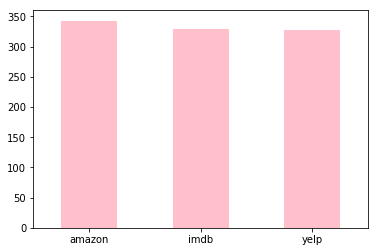

In [41]:
#using matplotlib  type(res_sample.label)=pandas series
res_sample.label.value_counts().plot(kind="bar", rot=0, color='pink')

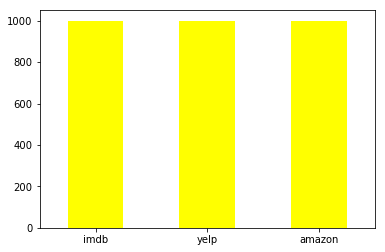

In [42]:
res.label.value_counts().plot(kind="bar", rot=0, color='yellow')

### 4.2 Feature Creation

In [43]:
import nltk
def tokenize_text(text, remove_stopwords=False):
    tokens = []
    for d in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(d, language='english'):
            # filters here
            tokens.append(word)
    return tokens

In [44]:
# takes a like a minute or two to process
res['words'] = res['sentence'].apply(lambda x: tokenize_text(x))

In [45]:
res[0:5]['words']

0    [So, there, is, no, way, for, me, to, plug, it...
1                 [Good, case, ,, Excellent, value, .]
2                        [Great, for, the, jawbone, .]
3    [Tied, to, charger, for, conversations, lastin...
4                             [The, mic, is, great, .]
Name: words, dtype: object

In [46]:
list(res[2:4]['words'])

[['Great', 'for', 'the', 'jawbone', '.'],
 ['Tied',
  'to',
  'charger',
  'for',
  'conversations',
  'lasting',
  'more',
  'than',
  '45',
  'minutes.MAJOR',
  'PROBLEMS',
  '!',
  '!']]

### 4.3 Feature subset selection

In [47]:
count_vect = CountVectorizer()
res_counts = count_vect.fit_transform(res.sentence)

In [48]:
analyze = count_vect.build_analyzer()
analyze(" ".join(list(res[4:5].sentence)))

['the', 'mic', 'is', 'great']

In [49]:
" ".join(list(res[0:4].sentence))

'So there is no way for me to plug it in here in the US unless I go by a converter. Good case, Excellent value. Great for the jawbone. Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!'

In [50]:
res_counts.shape

(3000, 5155)

In [51]:
count_vect.get_feature_names()[0:10]

['00', '10', '100', '11', '12', '13', '15', '15g', '15pm', '17']

In [52]:
res[0:5]

,sentence,score,label,words
0,So there is no way for me to plug it in here i...,0,amazon,"[So, there, is, no, way, for, me, to, plug, it..."
1,"Good case, Excellent value.",1,amazon,"[Good, case, ,, Excellent, value, .]"
2,Great for the jawbone.,1,amazon,"[Great, for, the, jawbone, .]"
3,Tied to charger for conversations lasting more...,0,amazon,"[Tied, to, charger, for, conversations, lastin..."
4,The mic is great.,1,amazon,"[The, mic, is, great, .]"


In [53]:
res_counts.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [54]:
count_vect.transform(['Something completely new.']).toarray()

array([[0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [55]:
count_vect.transform(['00 Something completely new ']).toarray()

array([[1, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
#Using heat map
plot_x = ["term_"+ str(i) for i in count_vect.get_feature_names()[0:80]]

In [57]:
plot_y = ["doc_"+ str(i) for i in list(res.index)[0:90]]

In [58]:
plot_z = res_counts[0:80, 0:80].toarray()

In [59]:
def plot_heat_map(plot_x, plot_y, plot_z):
    """ Helper to plot heat map """
    trace = {
        "x": plot_x,
        "y": plot_y,
        "z": plot_z,
        "colorscale": [[0.0, "rgb(158,1,66)"], [0.1, "rgb(213,62,79)"], [0.2, "rgb(244,109,67)"], [0.3, "rgb(253,174,97)"], [0.4, "rgb(254,224,139)"], [0.5, "rgb(255,255,191)"], [0.6, "rgb(230,245,152)"], [0.7, "rgb(171,221,164)"], [0.8, "rgb(102,194,165)"], [0.9, "rgb(50,136,189)"], [1.0, "rgb(94,79,162)"]],
        "type": "heatmap"
    }

    data = go.Data([trace])
    layout = {
        "legend": {
            "bgcolor": "#F5F6F9",
            "font": {"color": "#4D5663"}
        },
        "paper_bgcolor": "#F5F6F9",
        "plot_bgcolor": "#F5F6F9",
        "xaxis1": {
            "gridcolor": "#E1E5ED",
            "tickfont": {"color": "#4D5663"},
            "title": "",
            "titlefont": {"color": "#4D5663"},
            "zerolinecolor": "#E1E5ED"
        },
        "yaxis1": {
            "gridcolor": "#EC407A",
            "tickfont": {"color": "#4D5663"},
            "title": "",
            "titlefont": {"color": "#4D5663"},
            "zeroline": False,
            "zerolinecolor": "#E1E5ED"
        }
    }

    fig = go.Figure(data = data, layout=layout)
    return fig

In [60]:
# to plot
py.iplot(plot_heat_map(plot_x, plot_y, plot_z))

## 4.4 Dimension reduction

In [61]:
from sklearn.decomposition import PCA
res_reduced = PCA(n_components=3).fit_transform(res_counts.toarray())

In [62]:
res_reduced.shape

(3000, 3)

In [63]:
def get_trace(X_pca, data, category, color):
    """ Build trace for plotly chart based on category """
    trace = go.Scatter3d(
        x=X_pca[data.apply(lambda x: True if x==category else False), 0],
        y=X_pca[data.apply(lambda x: True if x==category else False),1],
        z=X_pca[data.apply(lambda x: True if x==category else False),2],
        mode='markers',
        marker=dict(
            size=4,
            line=dict(
                color=color,
                width=0.2
            ),
            opacity=0.8
        ),
        text=data[data.apply(lambda x: True if x==category else False).tolist()]
    )
    return trace

In [64]:
trace1 = get_trace(res_reduced, res["label"], "amazon", "rgb(71,233,163)")
trace2 = get_trace(res_reduced, res["label"], "yelp", "rgb(52,133,252)")
trace3 = get_trace(res_reduced, res["label"], "imdb", "rgb(229,65,136)")

In [65]:
data = [trace1, trace2, trace3]
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')

## 4.5 Atrribute Transformation / Aggregation

In [66]:
# note this takes time to compute. You may want to reduce the amount of terms you want to compute frequencies for
term_frequencies = []
for j in range(0,res_counts.shape[1]):
    term_frequencies.append(sum(res_counts[:,j].toarray()))

In [67]:
term_frequencies[0]

array([1], dtype=int64)

In [68]:
py.iplot(plot_word_frequency([count_vect.get_feature_names(), term_frequencies], "Term Frequency Distribution"))

In [69]:
term_frequencies_log = [math.log(i) for i in term_frequencies]

In [70]:
py.iplot(plot_word_frequency([count_vect.get_feature_names(), term_frequencies_log], "Term Frequency Distribution"))

## 4.6 Discretization and Binarization
You can see that the new attribute `bin_labe`, contains `0 and 1`. 

The `1` indicate the position of the label or category we binarized.                                                                   Attributes with continuous values also have strategies to tranform the data; this is usually called **Discretization** 

In [71]:
from sklearn import preprocessing, metrics, decomposition, pipeline, dummy
mlb = preprocessing.LabelBinarizer()

In [72]:
mlb.fit(res.label)

LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False)

In [73]:
mlb.classes_

array(['amazon', 'imdb', 'yelp'],
      dtype='<U6')

In [74]:
res['bin_label'] = mlb.transform(res['label']).tolist()

In [75]:
res[996:1010]

,sentence,score,label,words,bin_label
996,What a piece of junk.. I lose more calls on th...,0,amazon,"[What, a, piece, of, junk.., I, lose, more, ca...","[1, 0, 0]"
997,Item Does Not Match Picture.,0,amazon,"[Item, Does, Not, Match, Picture, .]","[1, 0, 0]"
998,The only thing that disappoint me is the infra...,0,amazon,"[The, only, thing, that, disappoint, me, is, t...","[1, 0, 0]"
999,"You can not answer calls with the unit, never ...",0,amazon,"[You, can, not, answer, calls, with, the, unit...","[1, 0, 0]"
1000,Wow... Loved this place.,1,yelp,"[Wow, ..., Loved, this, place, .]","[0, 0, 1]"
1001,Crust is not good.,0,yelp,"[Crust, is, not, good, .]","[0, 0, 1]"
1002,Not tasty and the texture was just nasty.,0,yelp,"[Not, tasty, and, the, texture, was, just, nas...","[0, 0, 1]"
1003,Stopped by during the late May bank holiday of...,1,yelp,"[Stopped, by, during, the, late, May, bank, ho...","[0, 0, 1]"
1004,The selection on the menu was great and so wer...,1,yelp,"[The, selection, on, the, menu, was, great, an...","[0, 0, 1]"
1005,Now I am getting angry and I want my damn pho.,0,yelp,"[Now, I, am, getting, angry, and, I, want, my,...","[0, 0, 1]"
